In [1]:
import pandas as pd
import random
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input as process_mobilenet
from tensorflow.keras.applications.inception_v3 import preprocess_input as process_inception
from tensorflow.keras.applications.resnet50 import preprocess_input as process_resnet
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as process_vgg
import itertools

import cv2

from sklearn.metrics import confusion_matrix, accuracy_score
# Start CoLab
try:
  from google.colab import drive
  %tensorflow_version 2.x
  drive.mount('/content/drive', force_remount=True)
  COLAB = True
  print("Note: using Google CoLab")
except:
  print("Note: not using Google CoLab")
  COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [3]:
### GENERATOR WRAPPER TO CREATE FAKE LABEL ###

def wrap_generator(generator):
    
    while True:
        x,y = next(generator)
        y = tf.keras.utils.to_categorical(y)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.])
        y = tf.concat([y,zeros], axis=0)
        yield x,y

In [4]:

### CREATE EMPTY GENERATORS ###

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

SHAPE = (224,224,3)

In [5]:
### FLOW GENERATORS ###

train_generator = train_datagen.flow_from_directory(
            '/content/drive/My Drive/Dataset_Project/Dataset 4',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = 256,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['no']
    )

test_generator = test_datagen.flow_from_directory(
            '/content/drive/My Drive/Dataset_Project/Dataset 2/',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = 256,
            class_mode = 'categorical',
            shuffle = False,
            seed = 33,
            classes = ['no','yes']
)

Found 1500 images belonging to 1 classes.
Found 253 images belonging to 2 classes.


In [6]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)



In [7]:
def get_model(train=True):
    set_seed(33)
    inp = Input((224,224,3))

    resnet = ResNet50(weights = 'imagenet', include_top = False)

    for layer in resnet.layers[:-4]:
        layer.trainable = False

    pre_1 = Lambda(process_resnet)
    resnet_process = pre_1(GaussianNoise(0.1)(inp))
    res_net = resnet(resnet_process)

    noise = Lambda(tf.zeros_like)(res_net)
    noise = GaussianNoise(0.1)(noise)

    if train:
        w = Lambda(lambda z: tf.concat(z, axis=0))([res_net ,noise])
        w = Activation('relu')(w)
    else:
        w = res_net 
  
    x_resnet = GlobalMaxPool2D()(w)
    x_resnet = Dense(1024, activation='relu')(x_resnet)

    a = x_resnet
        
    a = Dense(512, activation='relu')(a)
    a = Dense(128, activation='relu')(a)
    out = Dense(2, activation='softmax')(a)
 
    model = Model(inp, out)
    model.compile(Adam(lr=1e-3), loss='binary_crossentropy')
    
    return model

In [8]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'no': 0}
{'no': 0, 'yes': 1}


In [9]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=5)
model = get_model()
model.fit(wrap_generator(train_generator), steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=5)

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/5
5/5 [==============================] - 278s 47s/step - loss: 1.4135
Epoch 2/5
5/5 [==============================] - 246s 42s/step - loss: 1.8130
Epoch 3/5
5/5 [==============================] - 250s 43s/step - loss: 1.5943
Epoch 4/5
5/5 [==============================] - 243s 42s/step - loss: 0.7385
Epoch 5/5
5/5 [==============================] - 243s 41s/step - loss: 0.2432


In [10]:
  ### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
label_test.shape
print(label_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [11]:
### SWITCH TO INFERENCE MODE TO COMPUTE PREDICTIONS ###

ineference_model = get_model(train=False)

In [12]:
### COMPUTE PREDICTIONS ON TEST DATA ###

pred_test = np.argmax(ineference_model.predict(test_generator), axis=1)
print(pred_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0]


In [13]:

### ACCURACY ON TEST DATA ###

print('ACCURACY:', accuracy_score(label_test, pred_test))

ACCURACY: 0.4268774703557312


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

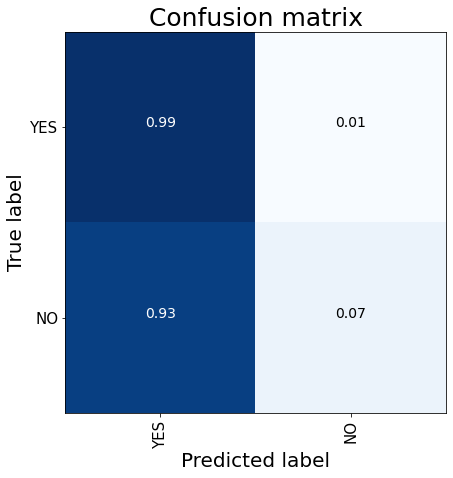

In [ ]:
### CONFUSION MATRIX ON TEST DATA ###

cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['YES','NO'])
plt.show()

In [ ]:
from sklearn .metrics import roc_auc_score 
from sklearn import metrics
print(roc_auc_score(label_test,pred_test))

0.5303818301514155


In [ ]:
resnet = get_model()
resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise_4 (GaussianNoise (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 224, 224, 3)  0           gaussian_noise_4[0][0]           
__________________________________________________________________________________________________
resnet50 (Functional)           (None, None, None, 2 23587712    lambda_5[0][0]                   
____________________________________________________________________________________________